In [22]:
!cat /home/ec2-user/ebs/volumes/era_session9/training_20241230_172545.log

2024-12-30 17:25:45 | INFO | Logging setup complete. Logs will be saved to: /home/ec2-user/ebs/volumes/era_session9/training_20241230_172545.log
2024-12-30 17:25:45 | INFO | Starting training with configuration:
2024-12-30 17:25:45 | INFO | PyTorch version: 2.5.1
2024-12-30 17:25:45 | INFO | Logging setup complete. Logs will be saved to: /home/ec2-user/ebs/volumes/era_session9/training_20241230_172545.log
2024-12-30 17:25:45 | INFO | Starting training with configuration:
2024-12-30 17:25:45 | INFO | PyTorch version: 2.5.1
2024-12-30 17:25:45 | INFO | Logging setup complete. Logs will be saved to: /home/ec2-user/ebs/volumes/era_session9/training_20241230_172545.log
2024-12-30 17:25:45 | INFO | Starting training with configuration:
2024-12-30 17:25:45 | INFO | PyTorch version: 2.5.1
2024-12-30 17:25:45 | INFO | CUDA available: True
2024-12-30 17:25:45 | INFO | CUDA device count: 4
2024-12-30 17:25:45 | INFO | CUDA available: True
2024-12-30 17:25:45 | INFO | CUDA device count: 4
2024-12-

In [21]:
!nvidia-smi

Mon Dec 30 17:42:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      On  |   00000000:38:00.0 Off |                    0 |
| N/A   78C    P0             75W /   72W |   18352MiB /  23034MiB |     99%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import os
import time

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from tqdm import tqdm
import copy
import multiprocessing

# Import custom libraries
from src.classifier import ResNet, Bottleneck
from src.utils import train, test, seed_everything
from src.trainer import Trainer

## Model Instantiated

In [19]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
seed_everything(42)

resnet_model = ResNet(Bottleneck, [3, 4, 6, 3]).to(device)

resnet_model_exp = copy.deepcopy(resnet_model)
resnet_model_exp = nn.DataParallel(resnet_model_exp)
resnet_model_exp = resnet_model_exp.to(device)

## LR Finder

In [14]:
train_transformation = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomResizedCrop(
                224,
                interpolation=transforms.InterpolationMode.BILINEAR,
                antialias=True,
            ),
            transforms.RandomHorizontalFlip(0.5),
            # Normalize the pixel values (in R, G, and B channels)
            transforms.Normalize(
                mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )

train_dataset = torchvision.datasets.ImageFolder(
    root="/home/ec2-user/ebs/volumes/imagenet/ILSVRC/Data/CLS-LOC/train", 
    transform=train_transformation
)
train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    sampler=train_sampler,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.56E-01


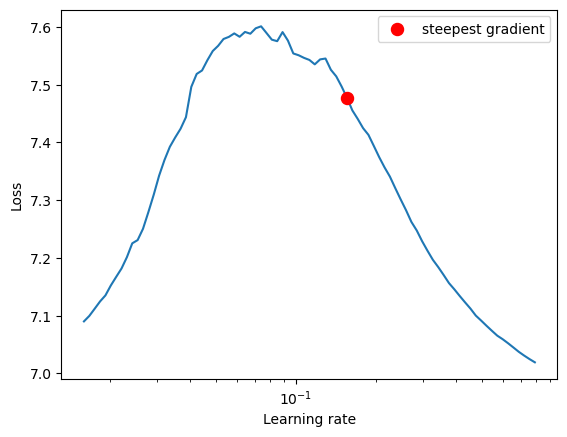

In [17]:
from torch_lr_finder import LRFinder

optimizer = optim.SGD(resnet_model_exp.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

amp_config = {
    'device_type': 'cuda',
    'dtype': torch.float16,
}
grad_scaler = torch.cuda.amp.GradScaler()

lr_finder = LRFinder(
    resnet_model_exp, 
    optimizer, 
    criterion, 
    device='cuda',
    amp_backend='torch', 
    amp_config=amp_config, 
    grad_scaler=grad_scaler
)
lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.14E-02


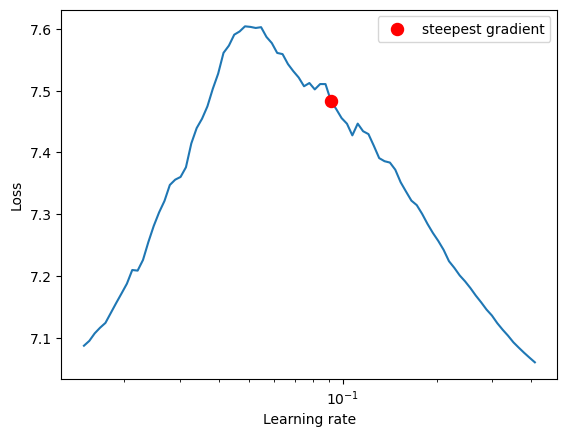

In [20]:
from torch_lr_finder import LRFinder

optimizer = optim.SGD(resnet_model_exp.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

amp_config = {
    'device_type': 'cuda',
    'dtype': torch.float16,
}
grad_scaler = torch.cuda.amp.GradScaler()

lr_finder = LRFinder(
    resnet_model_exp, 
    optimizer, 
    criterion, 
    device='cuda',
    amp_backend='torch', 
    amp_config=amp_config, 
    grad_scaler=grad_scaler
)
lr_finder.range_test(train_loader, end_lr=.5, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

## Training

In [4]:
## Checking number of cores available
import multiprocessing
multiprocessing.cpu_count()

48

In [5]:
config = {
    "train_path" : "/home/ec2-user/ebs/volumes/imagenet/ILSVRC/Data/CLS-LOC/train",
    "val_path" : "/home/ec2-user/ebs/volumes/imagenet/imagenet_validation",
    "batch_size" : 512,
    "num_workers" : multiprocessing.cpu_count(),
    "epochs" : 100,
    "artifact_path" : "/home/ec2-user/ebs/volumes/era_session9",
    "log_path": "/home/ec2-user/ebs/volumes/era_session9",
}

device = ('cuda' if torch.cuda.is_available() else 'cpu')
seed_everything(42)

optimizer = optim.SGD(resnet_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode="max",
#     factor=0.1,
#     patience=5,
#     verbose=False,
#     threshold_mode='rel',
#     threshold=0.0001,
#     min_lr=1e-6,
# )
# scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=epochs)

In [6]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.351,
    epochs=config["epochs"], 
    steps_per_epoch=len(train_loader),
    pct_start=0.3, 
    anneal_strategy='cos', 
    cycle_momentum=True, 
    base_momentum=0.85, 
    max_momentum=0.95, 
    div_factor=25.0, 
    final_div_factor=10000.0, 
    three_phase=False, 
    last_epoch=-1, 
    verbose='deprecated'
    )

In [ ]:
training = Trainer(
    model=resnet_model,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    train_path=config["train_path"],
    val_path=config["val_path"],
    batch_size=config["batch_size"],
    num_workers=config["num_workers"],
    epochs=config["epochs"],
    artifact_path=config["artifact_path"],
    log_path=config["log_path"],
)
training.main()

********* Epoch = 1 *********


loss=4.4648 batch_id=2502: 100%|██████████| 2503/2503 [36:25<00:00,  1.15it/s]  


Epoch 1: Train set: Average loss: 0.0110, Accuracy: 67105/1281167 (5.24%)




Test set: Average loss: 0.0092, Accuracy: 5791/50000 (11.58%)

LR =  [0.014040001236737265]
Test accuracy improved from 0.0000 to 11.5820. Saving model...
Checkpoint saved to /home/ec2-user/ebs/volumes/era_session9/best_model_epoch_1_acc_11.5820.pth
********* Epoch = 2 *********


loss=3.8516 batch_id=2089:  83%|████████▎ | 2090/2503 [35:13<08:59,  1.31s/it]   

In [7]:
config["batch_size"]

512

## Pytorch lightning code

In [ ]:
import os
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from loguru import logger

class ImageNetModule(LightningModule):
    def __init__(
        self,
        learning_rate: float = 0.1,
        momentum: float = 0.9,
        weight_decay: float = 1e-4,
        batch_size: int = 256,
        num_workers: int = 16,
        max_epochs: int = 90,
        data_dir: str = "path/to/imagenet",
    ):
        super().__init__()
        self.save_hyperparameters()
        
        # Model
        self.model = models.resnet50(weights=None)
        
        # Training parameters
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.max_epochs = max_epochs
        self.data_dir = data_dir
        
        # Set up transforms
        self.train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        
        self.val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
        
        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', accuracy, on_step=True, on_epoch=True)
        
        # Logging with loguru
        if batch_idx % 100 == 0:
            logger.info(f"Training - Epoch: {self.current_epoch}, Batch: {batch_idx}, "
                       f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
        
        return {'val_loss': loss, 'val_acc': accuracy}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = sum([x['val_acc'] for x in outputs]) / len(outputs)
        
        # Log metrics
        self.log('val_loss', avg_loss)
        self.log('val_acc', avg_acc)
        
        # Logging with loguru
        logger.info(f"Validation - Epoch: {self.current_epoch}, "
                   f"Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")

    def train_dataloader(self):
        train_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, 'train'),
            transform=self.train_transforms
        )
        return DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
        val_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, 'val'),
            transform=self.val_transforms
        )
        return DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.learning_rate,
            momentum=self.momentum,
            weight_decay=self.weight_decay
        )
        
        # OneCycleLR scheduler
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            epochs=self.max_epochs,
            steps_per_epoch=len(self.train_dataloader()),
            pct_start=0.1,
            anneal_strategy='cos'
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step"
            }
        }

def main():
    # Set up logging
    logger.add("training.log", rotation="100 MB")
    
    # Initialize model and trainer
    model = ImageNetModule(
        learning_rate=0.1,
        batch_size=256,
        num_workers=16,
        max_epochs=90,
        data_dir="/path/to/imagenet"
    )
    
    # Callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints",
        filename="resnet50-{epoch:02d}-{val_acc:.2f}",
        monitor="val_acc",
        mode="max"
    )
    
    # Initialize trainer
    trainer = Trainer(
        max_epochs=90,
        accelerator="gpu",
        devices=4,  # Using all 4 GPUs
        strategy="ddp",  # Distributed Data Parallel
        precision=16,  # Mixed precision training
        callbacks=[checkpoint_callback],
        logger=TensorBoardLogger("logs/", name="resnet50"),
    )
    
    # Start training
    trainer.fit(model)

if __name__ == "__main__":
    main()